Instructions:
-	Your solution for this assignment need to be in a pdf format
-	For programming question, your code should be well documented, so anyone reading it can understand what's happening.


# Problem 1: Conceptual

#### Requisites
Read relevant sections of *An Introduction to Statistical Learning* Ch.8 Tree-Based Methods

### a)	Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X , produce 10 estimates of P (Class is Red|X ):

```0. 1,  0. 15,  0. 2,  0. 2,  0. 55,  0. 6,  0. 6,  0. 65,  0. 7,  and 0. 75.```

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

### Solution

The first step is to generate the data shown above:

In [1]:
import numpy as np
estimates = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])
print(estimates)
num_estimates = np.shape(estimates)
print('There are %i estimates in total' % num_estimates)

[0.1  0.15 0.2  0.2  0.55 0.6  0.6  0.65 0.7  0.75]
There are 10 estimates in total


Assuming a decision threshold probability of 0.5, for the majority vote approach we need compare the number of instances where the estimate is greater than or equal to 0.5 (class Red) to the number of instances where the estimate is less than 0.5 (class Green). Whichever set has the largest number of instances determines the assigned class.

In [2]:
p_threshold = 0.5
numRed = np.sum(estimates >= p_threshold)
numGreen = np.sum(estimates < p_threshold)
print('Using the majority vote approach:\n')
print('The number of votes for class Red = %i' % numRed)
print('The number of votes for class Green = %i' % numGreen)
if numRed >= numGreen:
    print('The assigned class is Red')
else:
    print('The assigned class is Green')

Using the majority vote approach:

The number of votes for class Red = 6
The number of votes for class Green = 4
The assigned class is Red


For the average probability approach, we simply need to determine the mean of the 10 predictions and compare that value to the threshold probability.

In [3]:
print('Using the average vote approach:\n')
mean_estimate = np.mean(estimates)
print('The mean estimate is %f' % mean_estimate)
if mean_estimate >= p_threshold:
    print('The assigned class is Red')
else:
    print('The assigned class is Green')

Using the average vote approach:

The mean estimate is 0.450000
The assigned class is Green


In this case, the majority vote and average vote approachs produce different results. Part of the reason for the disagreement is that the average vote approach is more sensitive to values that are far from the threshold (the mean is sensitive to outliers). Within the estimates, even though there were only four values below the threshold, they were all closer to zero than they were to the threshold (less than or equal to 0.2). The six values above the threshold were all closer to the threshold than they were to one (none were above 0.75). Because of this, the mean of the estimates was pulled towards zero, resulting in a value below the threshold.

Consider the plot below, which shows a histogram of the estimates along with the threshold (black line) mean (red line) and median (blue line). The mean is pulled to the left of the threshold because of the cluster of estimates close to zero. The median is relatively unaffected by this and remains above the threshold.

Note that this behavior may be ok, as we might want stronger probabilities (either towards 0 or 1) to help influence the decision. It depends on the specific problem, so each approach should be used appropriately.

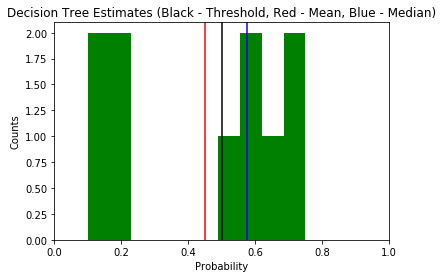

In [4]:
import matplotlib.pyplot as plt
plt.hist(estimates, color = 'green')
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.title('Decision Tree Estimates (Black - Threshold, Red - Mean, Blue - Median)')
plt.xlim([0,1])
# Add vertical lines to indicate mean and median
plt.axvline(x = p_threshold, color = 'black')
plt.axvline(x = mean_estimate, color = 'red')
plt.axvline(x = np.median(estimates), color = 'blue')
plt.show()

### b)	Provide a detailed explanation of the algorithm that is used to fit a regression tree.

At a high level, there are two steps to building a regression tree. 
1. Divide the predictor space into J distinct, non-overlapping regions. 
2. For any test observation that lands a given region, assign the mean response value for the training observations in that region. 

The first phase is the fitting phase, which will be explained in more detail:
1. When dividing the predictor space into $J$ distinct regions, each region is created such that the residual sum of squares (RSS) is minimized within the region. In other words, the sum of the squared differences between the actual and predicted response values is minimized.
2. Because it is not computationally feasible to consider all possible partitions, a greedy algorithm is used. A greedy algorithm looks for a local optimum at each step with the hope of finding a global optimum (in general, it does not find the global optimum, but rather a locally optimal solution in a reasonable amount of time).
3. The approach taken is called recursive binary splitting, which is a top-down, greedy algorithm. The greedy part was covered above, and the top-down part refers to the fact that the algorithm begins at the top of the tree (where no splits have been made yet) and successively splits the predictor space at each level. The algorithm is recursive because each split is performed in the same manner, just on a smaller subset of the predictor space.
4. Each time a split is made, both a predictor (denoted $X_J$) and a cutpoint (denoted $s$) are selected such that the region created by the split where $X_J$ is less than $s$ on one side and $X_J$ is greater than s on the other leads to the greatest possible reduction in RSS out of all possible predictors and all possible cutpoints. The algorithm is greedy in this case because it considers the best possible split at that step, without looking ahead to see if a different split could be more globally beneficial at some future step.
5. When considering a split, the RSS from the observations on one side of the split (call this region $R_1$) is added to the RSS from the observations on the other side of the split (call this region $R_2$) to compute the total RSS for the split. As mentioned above, the predictor and cutpoint that minimize this sum are chosen to make the split.
6. Within each region created by the split defined above, perform the same procedure again in a recursive fashion. This continues until a stopping criterion is reached, for example once the predictor space in a region contains less than some minimum number of samples.

# Problem 2: Train and fine-tune a Decision Tree

### a) Generate a moons dataset in sklearn using make_moons(n_samples=10000, noise=0.4) and split your data into a training set and a test set. 

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

#Split it into a training set and a test set using train_test_split().
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's take a look at the data that we just generated (in particular, the training set):

(8000, 2)
(8000,)
X data:
[[-0.56413534  0.29283681]
 [-1.16033479  0.96512577]
 [-0.06598769 -0.15191052]
 [-0.38613603  0.4118307 ]
 [ 0.053037    0.3737536 ]
 [ 0.57508824 -0.16323848]
 [-0.29712957  0.47121385]
 [ 0.0564801   0.44764934]
 [ 0.69109639 -0.03407157]
 [ 0.56185775  1.06121326]]
y data:
[0 0 1 0 1 1 0 0 0 0]


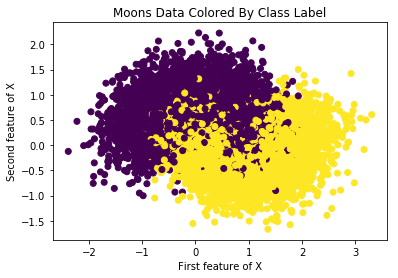

In [6]:
# Look at size of data set
print(np.shape(X_train))
print(np.shape(y_train))
print('X data:')
print(X_train[0:10,:])
print('y data:')
print(y_train[0:10])
# Make scatter plot
plt.scatter(X_train[:,0],X_train[:,1], c = y_train)
plt.xlabel('First feature of X')
plt.ylabel('Second feature of X')
plt.title('Moons Data Colored By Class Label')
plt.show()

Apparently we generated two overlapping 'crescents' of data. Our objective is to build a classifier using the training data and predict the class label from the test data, which follows the same pattern (both sets were randomly split from the same data).

### b) Use grid search with cross-validation (with the help of the GridSearchCV class) to find good hyperparameter values for a DecisionTreeClassifier. Hint: try various values for max_leaf_nodes.

Our first task is to perform a grid search over a set of parameters to determine the optimal values to use in our tree. The parameters we will be tuning are:
* min_samples_split - Minimum number of samples required to split an internal node
* min_samples_leaf - Minimum number of samples required in a leaf (terminal) node
* max_leaf_nodes - Maximum number of leaf nodes allowed in the tree
* max_depth - Maximum depth of tree (in levels)

We'll use 5-fold cross validation to evaluate each set of parameters in our search.

In [7]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import GridSearchCV

# Define parameters for grid search
params = {'min_samples_split':np.arange(2,9), 'min_samples_leaf':np.arange(1,9),
         'max_leaf_nodes':np.arange(20,31),'max_depth':np.arange(2,11)}
# Create decision tree object
dtc = DTC()
gsDTC = GridSearchCV(dtc,params,verbose=1,cv=5)
gsDTC.fit(X_train,y_train)

Fitting 5 folds for each of 5544 candidates, totalling 27720 fits


[Parallel(n_jobs=1)]: Done 27720 out of 27720 | elapsed:  5.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': array([2, 3, 4, 5, 6, 7, 8]), 'max_leaf_nodes': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

With our grid search completed, let's look at the optimum values of each of our parameters.

In [8]:
# Print best params from grid search
gsearch_params = gsDTC.best_params_
print(gsearch_params)

{'min_samples_split': 2, 'max_leaf_nodes': 23, 'max_depth': 6, 'min_samples_leaf': 4}


### c) Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly 85% to 87% accuracy (bonus point if you get more than 88% accuracy)

In [9]:
from sklearn.metrics import confusion_matrix
# Create a tree using the best params
moonsTree = DTC(min_samples_split=gsearch_params['min_samples_split'],
                max_leaf_nodes=gsearch_params['max_leaf_nodes'],
                min_samples_leaf=gsearch_params['min_samples_leaf'],
                max_depth=gsearch_params['max_depth'])

print(moonsTree)
# Fit to training data
moonsTree.fit(X_train,y_train)
# Predict values from test data
predVals = moonsTree.predict(X_test)
# Create confusion matrix
cmatrix = confusion_matrix(y_test,predVals)
print('\nConfusion matrix:')
print(cmatrix)
# Calculate accuracy
accuracy = float(np.sum(np.diag(cmatrix)))/len(y_test)
print('\nThe classification accuracy on the test set is %4.2f%%' % (accuracy*100))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=23, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Confusion matrix:
[[875 138]
 [115 872]]

The classification accuracy on the test set is 87.35%


### d) Generate 1,000 subsets of the training set, each containing 100 instances selected randomly (Hint: you can use Scikit-Learn's ShuffleSplit class for this). 

In [10]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []
# Create shuffle split and store indices for each of the 1000 trees
cdt_shuffle = ShuffleSplit(n_splits = n_trees, train_size = n_instances, test_size = 0)
train = cdt_shuffle.split(X_train)
for train_index,test_index in train:
    mini_sets.append(train_index)

### e) Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

In [11]:
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

forest = []
accuracy = []
# For each mini set, train a decision tree and evaluate on the full test set
# Store each tree and the accuracy of each
for mset in mini_sets:
    # Create single tree
    single_tree = DTC(min_samples_split=gsearch_params['min_samples_split'],
                max_leaf_nodes=gsearch_params['max_leaf_nodes'],
                min_samples_leaf=gsearch_params['min_samples_leaf'],
                max_depth=gsearch_params['max_depth'])
    # Train on current mini set
    single_tree.fit(X_train[mset,:],y_train[mset])
    # Evaluate on full test set
    predVals = single_tree.predict(X_test)
    # Generate confusion matrix
    cmatrix = confusion_matrix(y_test,predVals)
    # Compute accuracy
    acc = float(np.sum(np.diag(cmatrix)))/len(y_test)
    # Store tree and associated accuracy
    forest.append(single_tree)
    accuracy.append(acc)

Let's take a look at the accuracy of our 1,000 trees:

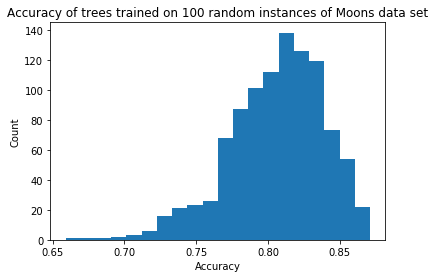

The median accuracy of the 1,000 trees was 81.05%


In [12]:
# Generate histogram of accuracy
plt.hist(accuracy,bins=20)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.title('Accuracy of trees trained on 100 random instances of Moons data set')
plt.show()
print('The median accuracy of the 1,000 trees was %4.2f%%' % (np.median(accuracy)*100))

As expected, because each tree was trained on only 100 randomly selected training instances, the median accuracy is significantly less than the tree trained on the full data set.

### f) For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's mode() function for this). This gives you majority-vote predictions over the test set.

In [13]:
# Create a 'RandomForest' class to evaluate test observations
class RandomForest:
    def __init__(self,trees):
        # Store trees that comprise forest
        self.Trees = trees
    def predict(self,observations):
        threshold = float(len(self.Trees))/2
        predict = []
        # Iterate over observations
        for obs in observations:
            preds = []
            # For each observation, generate class predictions from forest
            for tree in self.Trees:
                result = tree.predict(obs.reshape(1,-1))
                preds.append(result[0])
            # Determine majority class from all predictions and store
            if sum(preds) >= threshold:
                majority = 1
            else:
                majority = 0
            predict.append(majority)
        return predict
    
# Create random forest using set of 1,000 trees created above
rf = RandomForest(forest)
# Predict values from test set and return majority vote for each instance
predVals = rf.predict(X_test)

### g) Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

Let's generate the confusion matrix for our random forest predictions:

In [14]:
cmatrix = confusion_matrix(predVals,y_test)
print(cmatrix)

[[903 152]
 [110 835]]


From this, we can determine the accuracy:

In [15]:
accuracy = float(np.sum(np.diag(cmatrix)))/len(y_test)
print('\nThe random forest classification accuracy on the test set is %4.2f%%' % (accuracy*100))


The random forest classification accuracy on the test set is 86.90%


The accuracy of the random forest classifier is on par with the first model built, which was a single tree trained on the full data set. Since each tree within the random forest was trained on only 100 samples, the accuracy of each tree was significantly lower than the first model. However, when combined into a random forest ensemble, the accuracy increased because the ensemble model decreases the variance of the grouped predictions (recall that the variance of the mean of n independent observations is inversely proportional to n, so more observations means a lower variance). For an ensemble model, that means that average of n predictions (majority vote) coming from n independent models will have a lower variance than the prediction from one of the models.